In [222]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import scipy
import seaborn as sns
import pandas as pd
import sklearn

In [223]:
wdtable = Table.read('linefits.fits')
DA = (wdtable['spectral_class'] == 'DA')*(~np.isnan(wdtable['Teff']))*(~np.isnan(wdtable['log_g']))*\
        (wdtable['S/N'] > 20)
wdtable = wdtable[DA]

In [3]:
good = (
    (wdtable['fwhm_b'] < 120)*
    (wdtable['fwhm_a'] < 120)
)
wdtable = wdtable[good]

In [4]:
X = np.asarray(np.stack((
    wdtable['fwhm_b'],
    wdtable['fwhm_a'],
    wdtable['amplitude_a'],
    wdtable['amplitude_b'],
    wdtable['height_a'],
    wdtable['height_b'],
    wdtable['sigma_b'],
    wdtable['sigma_a'],
    wdtable['gamma_b'],
    wdtable['gamma_a']
))).transpose()


t = np.asarray(np.stack((
    wdtable['Teff'],
    wdtable['log_g']
))).transpose()

In [5]:
t.shape

(2414, 2)

In [6]:
data = pd.DataFrame(np.hstack((X,t)))

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,t)

In [9]:
clf = RandomForestRegressor(n_estimators = 100)

In [10]:
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [11]:
preds = clf.predict(X_test)
sklearn.metrics.r2_score(y_test,preds,multioutput = 'raw_values')

array([0.7633383 , 0.33207899])

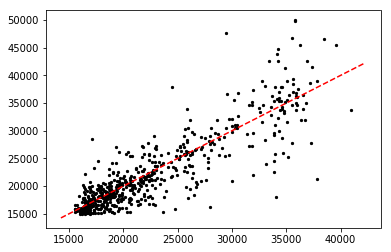

In [12]:
f = plt.scatter(preds[:,0],y_test[:,0], color='k', s = 5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

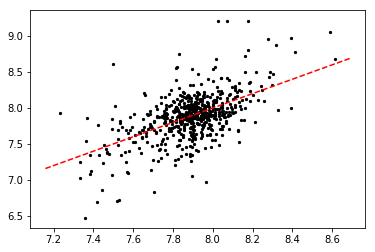

In [13]:
f = plt.scatter(preds[:,1],y_test[:,1], color='k', s = 5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

In [14]:
np.sqrt(sklearn.metrics.mean_squared_error(y_test[:,0],preds[:,0]))

3394.9044624367575

In [15]:
np.sqrt(sklearn.metrics.mean_squared_error(y_test[:,1],preds[:,1]))

0.2666462134069713

# GP Regression

In [227]:
X = np.asarray(np.stack((
    wdtable['fwhm_b'],
    wdtable['fwhm_a'],
    wdtable['amplitude_a'],
    wdtable['amplitude_b'],
    wdtable['height_a'],
    wdtable['height_b'],
    wdtable['sigma_b'],
    wdtable['sigma_a'],
    wdtable['gamma_b'],
    wdtable['gamma_a']
))).transpose()


t = np.asarray(np.stack((
    wdtable['log_g']
))).transpose()

In [228]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared

In [229]:
sc = StandardScaler()
msc = StandardScaler()

X_scaled = sc.fit_transform(X)
t_scaled = msc.fit_transform(t.reshape(-1,1))

X_train,X_test,y_train,y_test = train_test_split(X_scaled,t)

In [237]:
kernel = RBF() + WhiteKernel()
clf = GaussianProcessRegressor(normalize_y = True, kernel = kernel, n_restarts_optimizer = 5)

In [238]:
clf.fit(X_train,y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=5, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [239]:
print(clf.kernel_)
print(clf.log_marginal_likelihood())

RBF(length_scale=2.87) + WhiteKernel(noise_level=0.0726)
-507.1334931399633


0.2925889333909114

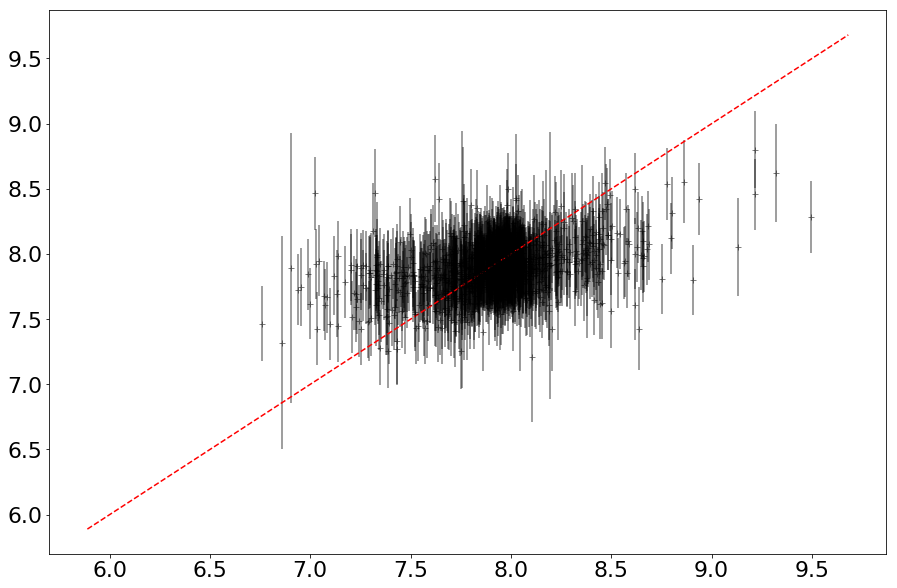

In [240]:
p,err = clf.predict(X_test,return_std = True)
preds =(p)
errs =  (err)
truths =(y_test)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

plt.errorbar(truths,preds,yerr = errs, color = 'k', linestyle = 'none', marker = '+', alpha = 0.5)

res =(truths - preds)
rms = np.sqrt(np.mean(res**2))
rms